## Import Libraries for Math, Distributions, Plotting

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
from scipy.stats import uniform
# from scipy.stats import chi2
from scipy.stats import gaussian_kde as gkde
from scipy.stats import multivariate_normal
# import scipy.stats as sstats 
from ipywidgets import *

In [3]:
def make_model(skew_range):
    # this function makes a linear map whos first component is the x-unit vector
    # and each subsequent component is a norm-1 vector satisfying the property
    # that the 2-2 map made from it and the aforementioned unit vector is a map
    # with skewness in skew_range, which is a list of desired skewnesses   
    # TODO currently this map only works for 2-D input space     
    
    def my_model(parameter_samples):
        Q_map = [ [1.0, 0.0] ] # all map components have the same norm, rect_size to have measures of events equal btwn spaces.
        for s in skew_range:
            Q_map.append( [np.sqrt(s**2 - 1), 1] ) # taken with the first component, this leads to a 2-2 map with skewsness 's'
        Q_map = np.array( Q_map )
        QoI_samples = np.dot(parameter_samples, np.transpose(Q_map))
        return QoI_samples
    return my_model

## Set Simulation Options

We are trying to determine the relationship between skewness and the number of samples required to approximate a solution to the inverse problem according to the $L^1$ metric (Total Variation).  

In [4]:
lambda_ref = np.array([0.5, 0.5])
# num_samples = np.array([1E2, 1E3, 1E4, 1E5]).astype('int') # independent variable
num_samples = np.array([1E2, 1E4]).astype('int')
# Number of Samples used for reference solution, number of trials
num_trials = 5
num_emulate = int(1E6)

# define some handles for functions we will use.
# prior_dist = np.random.uniform
prior_dist = uniform # can use any scipy.stats class
obs_dens = multivariate_normal

In [5]:
skew_range = np.array([1, 2, 4]) # skewnesses you want to compare
sigma = 1E-3
scale = 0.2
N = 2500

### Familiarize yourself with how the `make_model` function works.

Let us also familiarize ourselves with our observed density of choice and make sure we are not going to violate the predictability assumption. As skewness increases, it becomes necessary to lower the covariance of our observed density in order to prevent violation of the predictability assumption.


Do note that the uniform pdf has a bit of an interesting trick to get the pdf properly:

In [6]:
q_center = np.array([0.5, 1.25])
a = uniform(loc=q_center-0.5*scale, scale=scale)
x = np.array( [[0.5, 1.3], [0.5, 1.4], [0.5, 1.5]] )
np.prod(a.pdf(x), axis=1) # we have to do this... 

array([25.,  0.,  0.])

Whereas we can just do the following if our observed distribution object already has built-in support for multivariate cases.

In [7]:
b = multivariate_normal(mean=q_center, cov=sigma)
b.pdf(x) # instead of simply this.

array([4.55986546e+01, 2.07017572e-03, 4.26695018e-12])

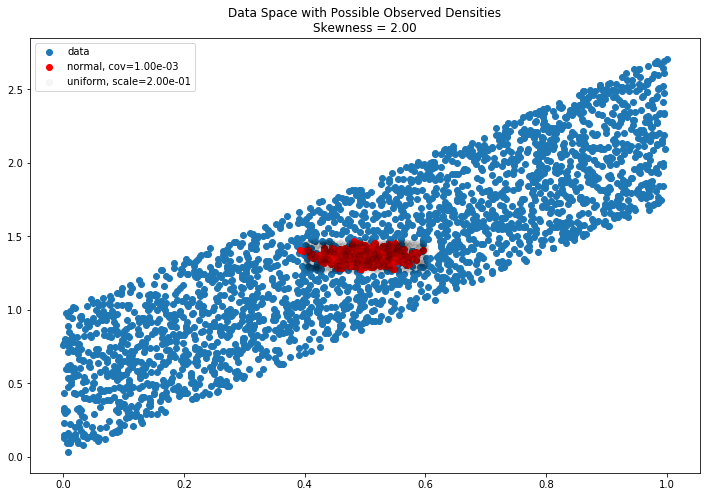

In [8]:
skewness = skew_range[1]

lam = prior_dist.rvs( size=(N, 2) ) # this is how we'll call the syntax later on as well
Q  = make_model([skewness])
D = Q(lam)
q_center = Q( lambda_ref )
obs_dens_samples_mult = multivariate_normal.rvs(mean=q_center, cov=sigma, size=(1000) )
obs_dens_samples_uni = uniform.rvs(loc=q_center-0.5*scale, scale=scale, size=(1000,2) )

plt.rcParams['figure.figsize'] = 12, 8
plt.cla()
plt.title('Data Space with Possible Observed Densities\nSkewness = %2.2f'%skewness)
plt.scatter(D[:,0], D[:,1], label='data')
plt.scatter(obs_dens_samples_mult[:,0], obs_dens_samples_mult[:,1], color='r', label='normal, cov=%2.2e'%sigma) 
plt.scatter(obs_dens_samples_uni[:,0], obs_dens_samples_uni[:,1], color='k', label='uniform, scale=%2.2e'%scale, alpha = 0.035) 
plt.legend()
# plt.axis('equal') 
# plt.show()
plt.savefig('skew_%d_scatter.png'%skewness)

We see from the above cell how to compare uniform distributions for our observed density to multivariate normals. 

For the MS report, a sidelength of $0.1$ was used for the uniform distribution in order to prevent violating the predictability assumption when skewness was equal to 4. Also note that the `loc` parameter passed to `scipy.stats.uniform` needs to be shifted to account for the center, as it is referring to the bottom-left corner instead in $\mathbb{R}^2$.  

With `sigma = 3E-4`, we find that the multivariate normal closely approximates the aforementioned uniform with sidelength $0.1$. Using these, we can safely go up to `skewness=6` before violating the assumption of predictability (dominating measure). 

Similarly, we can go up to `skew=4` with `cov=1E-3` and `scale=0.2`

## Define QoI
The following linear map $Q_s: \mathbb{R}^2 \to \mathbb{R}^2$ is defined to have skewness $s$ at all $\lambda \in \Lambda$.  

$$
Q_s(\lambda) = \lbrace \, \lambda_1, \; \lambda_1 \sqrt{s^2 - 1} + \lambda_2 \, \rbrace
$$

## Run Experiment

In [14]:
ell_1_error = np.zeros( (skew_range.size, num_samples.size, num_trials) )

for s_idx, s in enumerate(skew_range):
    print('Skewness = ', s)
    lam_emulate = prior_dist.rvs( size=(num_emulate, 2) )
    Q = make_model([s])
    q_emulate = Q( lam_emulate )
    pf_dens_ref = gkde(q_emulate.transpose()) # reference pushforward density
    
    q_center = Q(lambda_ref)
    obs = multivariate_normal(mean=q_center, cov=sigma) # define the handle, can now call .pdf

    for N_idx, N in enumerate(num_samples):
        for k in range(num_trials):
            print( '(skew, N, k) = (%d, %d, %d)'%(s, N, k) )
            lam = prior_dist.rvs( size=(N, 2) ) # generate some coarse approximations 
            q = Q( lam )
            pf_dens_approx = gkde(q.transpose())
            
            ell_1_error[s_idx, N_idx, k]= ( 1.0/N * np.sum( np.abs(
                obs.pdf(q)*(  1/pf_dens_ref.pdf(q.transpose()) - 1/pf_dens_approx.pdf(q.transpose())  ) )) )

Skewness =  1
(skew, N, k) = (1, 100, 0)
(skew, N, k) = (1, 100, 1)
(skew, N, k) = (1, 100, 2)
(skew, N, k) = (1, 100, 3)
(skew, N, k) = (1, 100, 4)
(skew, N, k) = (1, 10000, 0)
(skew, N, k) = (1, 10000, 1)
(skew, N, k) = (1, 10000, 2)
(skew, N, k) = (1, 10000, 3)
(skew, N, k) = (1, 10000, 4)
Skewness =  2
(skew, N, k) = (2, 100, 0)
(skew, N, k) = (2, 100, 1)
(skew, N, k) = (2, 100, 2)
(skew, N, k) = (2, 100, 3)
(skew, N, k) = (2, 100, 4)
(skew, N, k) = (2, 10000, 0)
(skew, N, k) = (2, 10000, 1)
(skew, N, k) = (2, 10000, 2)
(skew, N, k) = (2, 10000, 3)
(skew, N, k) = (2, 10000, 4)
Skewness =  4
(skew, N, k) = (4, 100, 0)
(skew, N, k) = (4, 100, 1)
(skew, N, k) = (4, 100, 2)
(skew, N, k) = (4, 100, 3)
(skew, N, k) = (4, 100, 4)
(skew, N, k) = (4, 10000, 0)
(skew, N, k) = (4, 10000, 1)
(skew, N, k) = (4, 10000, 2)
(skew, N, k) = (4, 10000, 3)
(skew, N, k) = (4, 10000, 4)


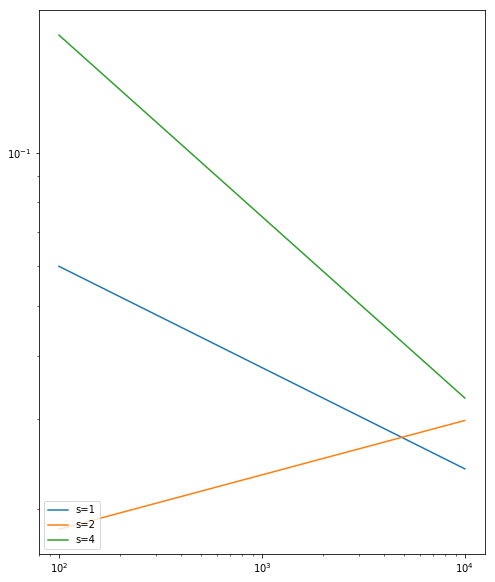

In [18]:
for s_idx, s in enumerate(skew_range):
    plt.loglog(num_samples, np.mean(ell_1_error[s_idx,:,:],axis=1), label='s=%d'%s)
plt.legend(loc=3)

plt.savefig('convergence_linearQ_param_skew_vs_samples.pdf')

In [19]:
print( np.mean( ell_1_error[0,:,:],axis=1)/np.mean(ell_1_error[2,:,:], axis=1) ) # convergence rate

[ 0.35146887  0.72595465]


In [ ]:
num_samples = np.array([1E2, 1E3, 1E4, 1E5]).astype('int')

lam_dim = np.array([10])

#num_emulate = int(1E5)

q_dim = np.array([1, 2, 5])

In [ ]:
plt.plot(x,post_dens_TP.evaluate(x))